# Transfer Learning with TensorFlow Part 1: feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

There are two mais benefits:

* Can leverage an existing neural network architecture proven to work on problems similar to our own.
* Can leverage a working neural netwrok architecture wich has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [44]:
# ============================================================
# TensorFlow CPU Optimization – Universal Notebook Cell
# Works for: simple models + transfer learning
# Target: Ryzen / Geekom A9 Max (96GB RAM)
# ============================================================

import os
import tensorflow as tf


# ----------- Silenciar logs ----------
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# ----------- oneDNN (AMD / Ryzen) ----
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1"

# ----------- CPU threading -----------
# Auto-scale = melhor equilíbrio para treino e fine-tuning
tf.config.threading.set_intra_op_parallelism_threads(0)
tf.config.threading.set_inter_op_parallelism_threads(0)

# ----------- Device placement --------
tf.config.set_soft_device_placement(True)

# ----------- Mixed Precision ----------
# Funciona bem tanto para CNNs simples quanto TL
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_bfloat16")

# ----------- tf.data defaults --------
AUTOTUNE = tf.data.AUTOTUNE

print("✅ TensorFlow pronto: CPU otimizado | simples + transfer learning")


✅ TensorFlow pronto: CPU otimizado | simples + transfer learning


# Download and becoming one with the data

In [45]:
# # Get the data (10% of 10 food class from food101 dataset)
# # https://www.kaggle.com/datasets/dansbecker/food-101

# #import zipfile
# #import urllib.request

# #Baixar o arquivo ZIP
# url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
# zip_path = "food_classes_10_percent.zip"
# urllib.request.urlretrieve(url, zip_path)

# # # Descompactar o arquivo ZIP
# with zipfile.ZipFile(zip_path, "r") as zip_ref:
#     zip_ref.extractall()

In [46]:
# How many images in each folder?
import os

#WEalk through 10 percent data directory and list number of file
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Create data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [47]:

# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with Tensorboard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [48]:
# Create TensorBoard callback (functionize because we need to create a new one for each model)
import datetime # to help create unique log directory names
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # create log directory
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir) # create TensorBoard callback
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

> Note: You can customize the directory where your TensorBoared logs (model training metrics) get saved to whatever you like.
The `log_dir` parameter we've created above is only one option.)

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layers by layer from scratch.
Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.
We can access pretrained models on: https://tfhub.dev/

Browsing the tensdorflow Hub page and sorting for image classification, we found the following feature vector model link: https://www.kaggle.com/models/google/efficientnet-v2


In [49]:
# Classificação ImageNet
resnet_v2_url = "https://tfhub.dev/tensorflow/resnet_50/classification/1"

# Ou para recursos (feature vectors):
resnet_feature_url = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [50]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [51]:
# let's make a create_model() function to reuse for each model

from os import name


def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
    Args:
      model_url (str): A TensorFlow Hub feature extraction URL.
      num_classes (int): Number of output neurons/classes in the output layer, should be equal to Number of target classes,
        default 10.

    Returns:
      An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer  with num_classes output neurons. 
    """
    
    # Temporarily set policy to float32 to avoid mixed precision conflicts with Hub layers
    from tensorflow.keras import mixed_precision
    original_policy = mixed_precision.global_policy()
    mixed_precision.set_global_policy("float32")

    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             name=f"feature_extractor_layer", 
                                             input_shape=IMAGE_SIZE+(3,), # add 3 color channels to the image size
                                             trainable=False) # freeze the already learned patterns

    # Create our own model
    model = tf.keras.Sequential([
            feature_extractor_layer,
            layers.Dense(num_classes, activation="softmax", name="output_layer")
        ])
    
    # Restore original policy
    mixed_precision.set_global_policy(original_policy)

    return model

### Creating and testing ResNet TensorFlow Hub Feature Estraction model

In [52]:
# Create Resnet model
resnet_model = create_model(resnet_v2_url,
                             num_classes=train_data_10_percent.num_classes)

In [53]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [54]:
for layer in resnet_model.layers[:-30]:
    layer.trainable = False

In [55]:
# Let's fit our resNet model to the data (10 percent of the food101 dataset)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2_feature_extraction")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2_feature_extraction/20260118-155656
Epoch 1/5
24/24 [==============================] - 47s 2s/step - loss: 2.2960 - accuracy: 0.2307 - val_loss: 2.2867 - val_accuracy: 0.2668
Epoch 2/5
24/24 [==============================] - 43s 2s/step - loss: 2.2786 - accuracy: 0.3573 - val_loss: 2.2695 - val_accuracy: 0.3692
Epoch 3/5
24/24 [==============================] - 57s 2s/step - loss: 2.2623 - accuracy: 0.3973 - val_loss: 2.2525 - val_accuracy: 0.4080
Epoch 4/5
24/24 [==============================] - 45s 2s/step - loss: 2.2460 - accuracy: 0.4720 - val_loss: 2.2356 - val_accuracy: 0.5276
Epoch 5/5
24/24 [==============================] - 43s 2s/step - loss: 2.2296 - accuracy: 0.5213 - val_loss: 2.2193 - val_accuracy: 0.5444


In [56]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1001)              25612201  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25622221 (97.74 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 25612201 (97.70 MB)
_________________________________________________________________


That is Increadible!!!. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and quicker training time AND with only 10% of the training examples.

In [57]:
# let's create a function to plot loss curves
#Tidbit: you could put this in a separate helper.py file and import it wherever you need it
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
      history: TensorFlow model History object (returned from model.fit()).
    Returns:
      Plots of training/validation loss and accuracy curves.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

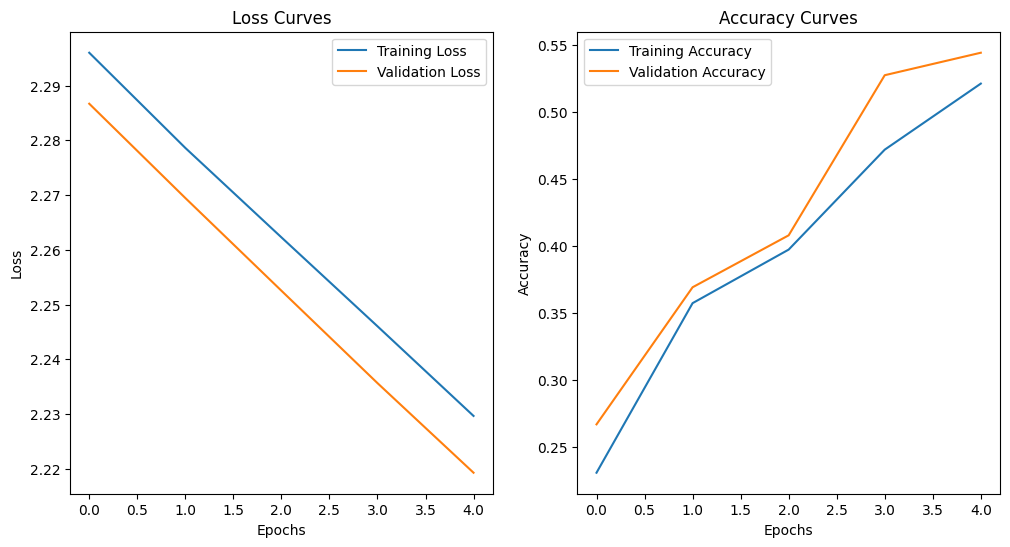

In [58]:
plot_loss_curves(resnet_history)

### Creating a testing EfficientNet Tensorflow Hub feature extraction model

In [ ]:
# Create EfficientNet feature extractor model  -- https://research.google/blog/efficientnet-improving-accuracy-and-efficiency-through-automl-and-model-scaling/
EfficientNet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
EfficientNet_model.compile(loss="categorical_crossentropy",
                             optimizer=tf.keras.optimizers.Adam(),
                             metrics=["accuracy"])

# Let's fit our EfficientNet model to the data (10 percent of the food101 dataset)
EfficientNet_history = EfficientNet_model.fit(train_data_10_percent,
                                                epochs=5,
                                                steps_per_epoch=len(train_data_10_percent),
                                                validation_data=test_data,
                                                validation_steps=len(test_data),
                                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                experiment_name="EfficientNetB0_feature_extraction")])



Saving TensorBoard log files to: tensorflow_hub/EfficientNetB0_feature_extraction/20260118-160419
Epoch 1/5
24/24 [==============================] - 19s 603ms/step - loss: 1.8581 - accuracy: 0.4187 - val_loss: 1.3135 - val_accuracy: 0.7240
Epoch 2/5
24/24 [==============================] - 13s 565ms/step - loss: 1.0438 - accuracy: 0.7947 - val_loss: 0.8813 - val_accuracy: 0.8128
Epoch 3/5
24/24 [==============================] - 13s 567ms/step - loss: 0.7469 - accuracy: 0.8480 - val_loss: 0.7083 - val_accuracy: 0.8412
Epoch 4/5
24/24 [==============================] - 13s 573ms/step - loss: 0.5996 - accuracy: 0.8773 - val_loss: 0.6206 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 14s 595ms/step - loss: 0.5075 - accuracy: 0.8907 - val_loss: 0.5695 - val_accuracy: 0.8596


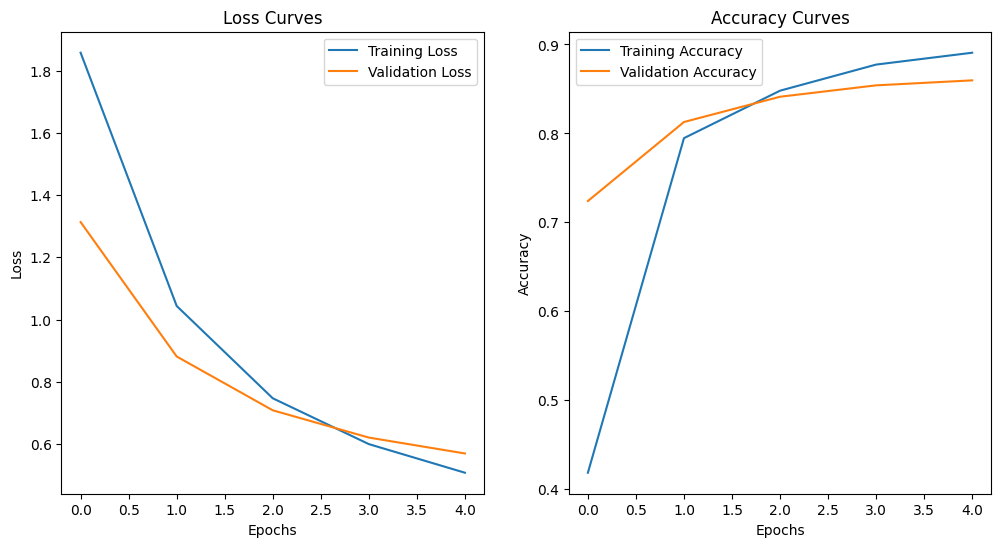

In [61]:
plot_loss_curves(EfficientNet_history)

In [62]:
EfficientNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1280)              4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [63]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (K  (None, 1001)              25612201  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 25622221 (97.74 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 25612201 (97.70 MB)
_________________________________________________________________


In [66]:
# How many layers does our efficientnet feature extractor have?
len(EfficientNet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet on your own)
* "**Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an a existing model and "fine-tune" many or all of the underling layers (includying new outputs layers)


## Comparing our models resulting using TensorBoard

> **Note:** When you upload things to TensorBoard.dev, your experiments are puplic. So, if you're running private experiments, do not upload then to TensorBoard.dev

In [70]:
# Upload Tensorboard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs. ResNet50V2" --description "Comparing two different TF Hub feature extraction models on 10 percent of the Food101 dataset." --one_shot




****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorboard.dev/ is no longer
supported.

TensorBoard.dev is shutting down.

Please export your experiments by Dec 31, 2023.

See the FAQ at https://tensorboard.dev.

****************************************************************
****************************************************************
****************************************************************
